# Unsupervised Learning / Data Analytics 1
## Structure
1. Structure

2. Overview

3. Preprocessing

4. Post Analysis
    1. Post Length
    2. Temporal Analysis
    3. Topic Modelling
    4. Named Entity Recognition
    5. Sentiment Analysis
    6. Duplicate Posts

5. User Analysis
    1. Post Frequency
    2. Most Active Users

6. Network Analysis
    1. Degree Centrality
    2. Eigenvector Centrality
    3. Clustering Coefficients
    4. Closeness Centrality
    5. Betweenness Centrality
    6. Inspection of Friendships
    7. Community Analysis

7. Stream Clustering
    1. Pipeline & textClust Setup
    2. Visualization

8. Duplicate Text Analysis
    1. Cluster Content
    2. User and Post Cluster-Analysis

## Overview

In [1]:
# Download and install the necessary resources
# !python3 -m spacy download en_core_web_sm
# pip install community
# pip install python-louvain
# nltk.download('stopwords')
# nltk.download('wordnet')

In [2]:
import json
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
from collections import Counter, defaultdict
from community import community_louvain
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
from river import cluster, compose, feature_extraction
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from spacy import load
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

In [3]:
primary = '#333F48'
dark_blue = '#00578A'
light_blue = '#009DD1'

## Preprocessing

In [4]:
def load_data(path_data='./data/dataset.json', logs=False):   
    with open(path_data, 'r') as file:
        data = json.load(file)
        df = pd.json_normalize(data)
    
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')

    if logs:
        # Summary of cleaning
        print("\nCleaned DataFrame:")
        print(df.info())

        # Display a few rows of the cleaned DataFrame
        print("\nCleaned DataFrame Head:")
        print(df.head())
    return df

In [5]:
def normalize_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove extra whitespaces
    text = text.strip()

    # Remove numbers (from preprocess_lemmatizer)
    text = re.sub(r'\d+', '', text)

    # Tokenize and process words
    words = text.split()

    # Remove stopwords
    words = [word for word in words if word not in nltk.corpus.stopwords.words("english")]

    # Lemmatize words
    lemmatizer = nltk.stem.WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

def normalize_data(df):
    # Apply the normalization function to the 'text' column
    df['text_preprocessed'] = df['text'].apply(normalize_text)
    return df

In [6]:
df = load_data()
df = normalize_data(df)

## Post Analysis
### Post Length

In [29]:
# Use original posts without lemmetization and further preprocessing to evaluate the realistic post length
original_posts = load_data()

Average text length: 198.93
Median text length: 195


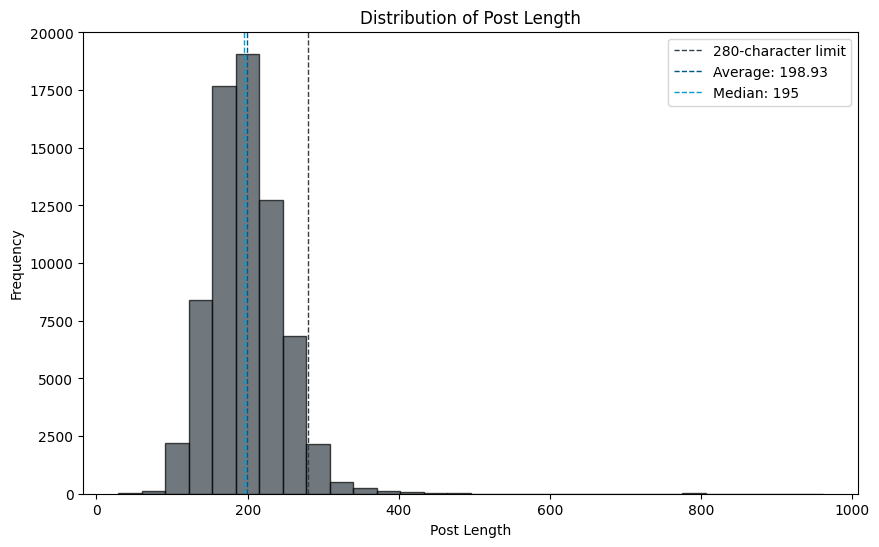

In [14]:
# Compute the length of each text
original_posts['text_length'] = original_posts['text'].apply(len)

# Calculate average and median text length
average_length = original_posts['text_length'].mean()
median_length = original_posts['text_length'].median()

print(f"Average text length: {round(average_length,2)}")
print(f"Median text length: {int(median_length)}")

# Plot the distribution of text length
plt.figure(figsize=(10, 6))
plt.hist(original_posts['text_length'], bins=30, edgecolor='k', alpha=0.7, color=primary)
plt.axvline(x=280, color=primary, linestyle='--', linewidth=1, label='280-character limit')
plt.axvline(x=average_length, color=dark_blue, linestyle='--', linewidth=1, label=f'Average: {round(average_length, 2)}')
plt.axvline(x=median_length, color=light_blue, linestyle='--', linewidth=1, label=f'Median: {int(median_length)}')

plt.title('Distribution of Post Length')
plt.xlabel('Post Length')
plt.ylabel('Frequency')
plt.legend()  # Add legend to explain the vertical line
plt.show()

The average post length of approximately 199 characters suggests the dataset likely originates from X (formerly Twitter), where free users have a 280-character limit. X Premium subscribers can post tweets up to 25,000 characters, indicating the presence of longer posts in the dataset.

### Temporal Analysis

In [15]:
print(f"Earliest timestamp: {df['datetime'].min()}, Latest timestamp: {df['datetime'].max()}")

Earliest timestamp: 2024-10-31 00:00:00, Latest timestamp: 2024-10-31 23:59:59


The data basis is limited to one day (31st October 2024).

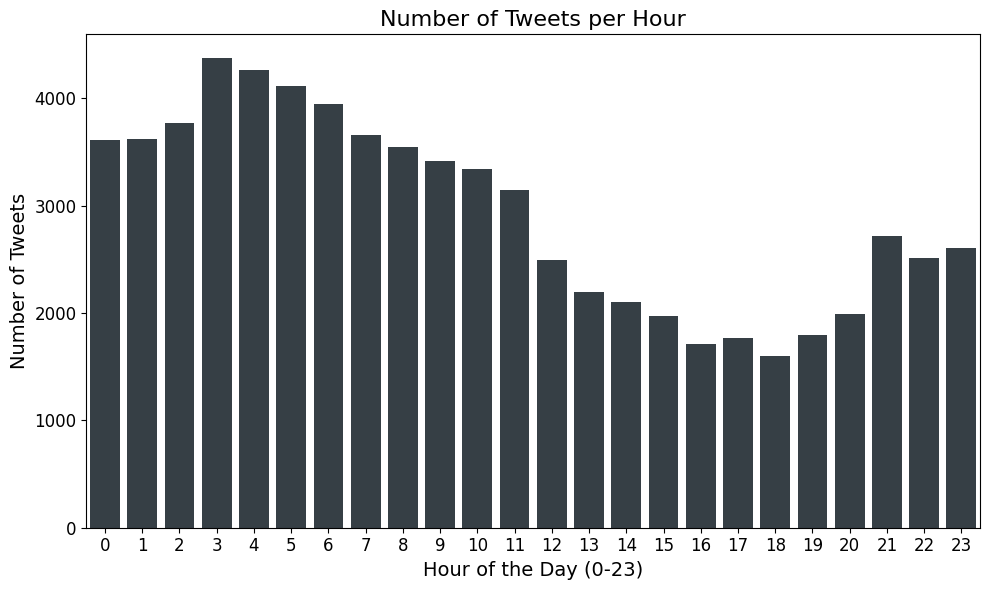

In [16]:
hourly_tweets= df['datetime'].dt.hour.value_counts().sort_index()
hours = hourly_tweets.index
tweet_counts = hourly_tweets.values

# Set up the figure
plt.figure(figsize=(10, 6))
sns.barplot(x=hours, y=tweet_counts, color=primary)
plt.title("Number of Tweets per Hour", fontsize=16)
plt.xlabel("Hour of the Day (0-23)", fontsize=14)
plt.ylabel("Number of Tweets", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

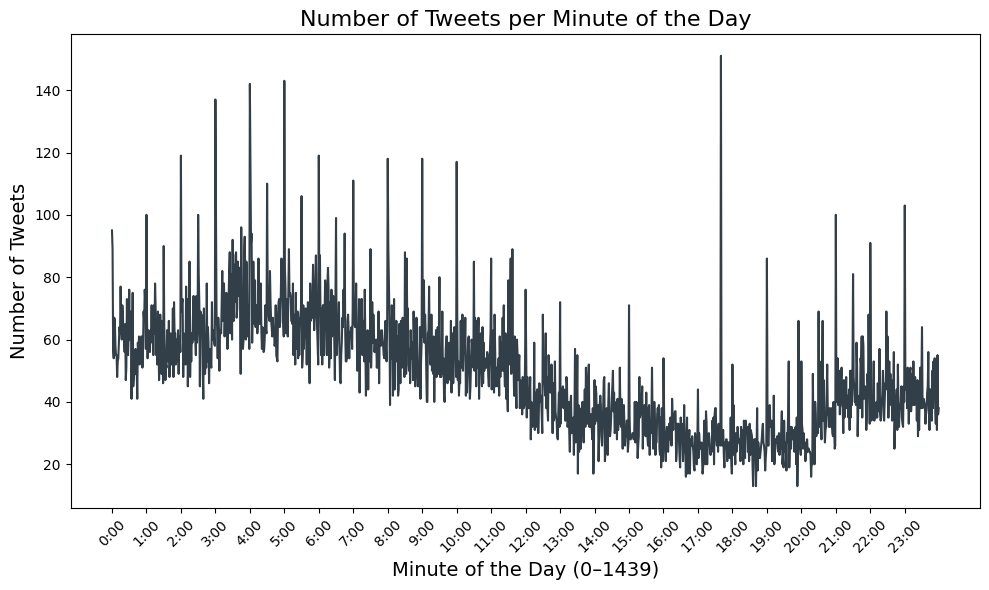

In [21]:
minute_tweets = (df['datetime'].dt.hour * 60 + df['datetime'].dt.minute).value_counts().sort_index()
minutes = minute_tweets.index
tweet_counts = minute_tweets.values

plt.figure(figsize=(10, 6))
sns.lineplot(x=minutes, y=tweet_counts, color=primary, linewidth=1.5)
plt.title("Number of Tweets per Minute of the Day", fontsize=16)
plt.xlabel("Minute of the Day (0–1439)", fontsize=14)
plt.ylabel("Number of Tweets", fontsize=14)
plt.xticks(ticks=range(0, 1440, 60), labels=[f"{i}:00" for i in range(24)], rotation=45)
plt.tight_layout()
plt.show()

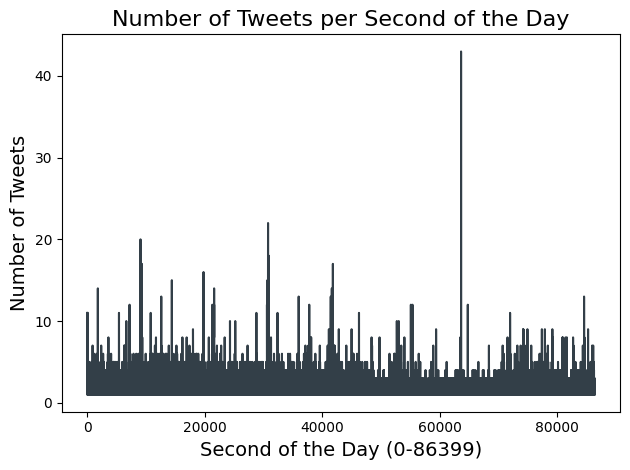

In [22]:
second_tweet = (
    df['datetime'].dt.hour * 3600 +
    df['datetime'].dt.minute * 60 +
    df['datetime'].dt.second
).value_counts().sort_index()
seconds = second_tweet.index
tweet_counts = second_tweet.values

sns.lineplot(x=seconds, y=tweet_counts, color=primary, linewidth=1.5)
plt.title("Number of Tweets per Second of the Day", fontsize=16)
plt.xlabel("Second of the Day (0-86399)", fontsize=14)
plt.ylabel("Number of Tweets", fontsize=14)
plt.tight_layout()
plt.show()

The temporal analysis in hours shows a seemingly normal distribution of tweets over time. However, looking at shorter timeframes, such as minutes or seconds, unveils the existence of periods where suspiciously many tweets occur. Let’s investigate!

In [43]:
#show the top 5 seconds with the most tweets
second_tweet.nlargest(5)

datetime
63653    43
63654    34
63652    26
30785    22
9065     20
Name: count, dtype: int64

In [44]:
#show the tweets from the second with the most tweets
df[(df['datetime'].dt.hour * 3600 +
    df['datetime'].dt.minute * 60 +
    df['datetime'].dt.second) == 63653]["text"].head(5)

56463    Bring comfort dogs to every university lecture...
56464    Bring comfort dogs to every university lecture...
56465    Bring comfort dogs to every university lecture...
56466    Bring comfort dogs to every university lecture...
56467    Bring comfort dogs to every university lecture...
Name: text, dtype: object

In [45]:
#print post from the outlier second
specific_text = df['text'].iloc[56463]
print(specific_text)

Bring comfort dogs to every university lecture! 🎓❤🐶️ Let's make our campuses fluffy again! Join the movement! #PawsForLearning #UniMS


In [46]:
print(f"This Text occurs {len(df[df['text'] == specific_text])} times in the dataset")

This Text occurs 130 times in the dataset


### Topic Modelling

In [7]:
# Convert the text df into a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['text_preprocessed'])

# Define the specific values for n_components
topic_values = [3, 6, 10, 15, 20]

# Initialize variables to store results
best_num_topics = None
best_model = None
best_perplexity = np.inf  # Lower perplexity is better

# Store all models for comparison
models = {}

# Loop through the specified number of topics
for n_topics in topic_values:
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(doc_term_matrix)  # Fit the model on the full dataset
    perplexity = lda.perplexity(doc_term_matrix)  # Evaluate perplexity

    print(f"Number of topics: {n_topics}, Perplexity: {perplexity:.2f}")
    
    # Store the model and its perplexity
    models[n_topics] = {
        "model": lda,
        "perplexity": perplexity
    }

    # Update the best model if this one is better
    if perplexity < best_perplexity:
        best_num_topics = n_topics
        best_model = lda
        best_perplexity = perplexity

# Output the best number of topics and corresponding perplexity
print(f"\nNumber of topics with best perplexity score: {best_num_topics}, Perplexity: {best_perplexity:.2f}")

Number of topics: 3, Perplexity: 5396.52
Number of topics: 6, Perplexity: 5088.83
Number of topics: 10, Perplexity: 4713.48
Number of topics: 15, Perplexity: 4589.52
Number of topics: 20, Perplexity: 4537.36

Number of topics with best perplexity score: 20, Perplexity: 4537.36


We have chosen 10 topics as the sweet spot between interpretability and perplexity because with 15 topics there were less useful and insignificant terms (e.g., "let," "yhawkins", "don") and lacked complete coherence.

In [8]:

# Actively choose the desired number of topics (e.g., 10 topics)
chosen_num_topics = 10  # Change this number to select a different model
if chosen_num_topics in models:
    chosen_model = models[chosen_num_topics]["model"]
    chosen_perplexity = models[chosen_num_topics]["perplexity"]
    print(f"\nChosen Number of Topics: {chosen_num_topics}, Perplexity: {chosen_perplexity:.2f}")
else:
    print(f"\nError: Model with {chosen_num_topics} topics not found.")
    chosen_model = None

# Get the top words for each topic from the chosen model
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[-num_top_words:]]))

# Display topics using the chosen model (if valid)
if chosen_model:
    num_top_words = 10  # Number of top words to display per topic
    feature_names = vectorizer.get_feature_names_out()
    display_topics(chosen_model, feature_names, num_top_words)


Chosen Number of Topics: 10, Perplexity: 4713.48
Topic 1:
ywagner, missing, katherine, para, precip, snow, oct, climate, low, high
Topic 2:
make, got, help, marketing, looking, like, hey, need, check, business
Topic 3:
change, politics, like, climate, trump, truss, new, check, energy, business
Topic 4:
vaccine, like, love, day, need, health, wishing, good, let, covid
Topic 5:
scotradar, united, alt, climateemergency, cop, ft, seen, unknown, politics, time
Topic 6:
history, hey, focus, change, people, time, political, let, science, politics
Topic 7:
crucial, need, wellbeing, check, issue, support, care, healthcare, mental, health
Topic 8:
love, bbmas, army, social, voting, btsbbmas, artist, let, vote, yhawkins
Topic 9:
like, air, need, life, climate, dont, make, change, let, time
Topic 10:
learn, science, opportunity, new, join, miss, latest, dont, check, business


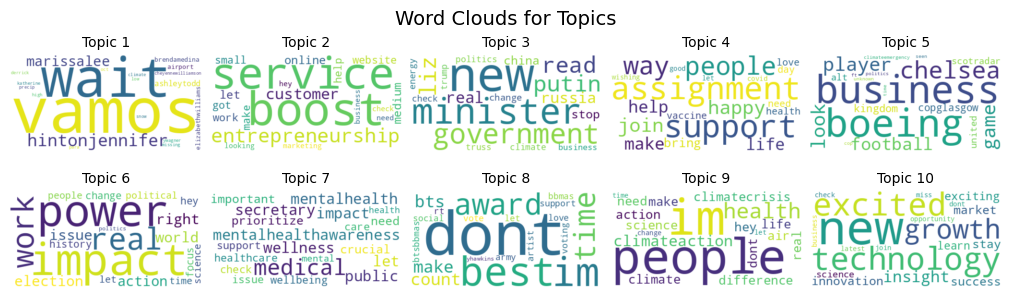

In [12]:
# Function to create word clouds for each topic
def visualize_wordclouds(lda_model, feature_names, num_words=20):
    """
    Visualize word clouds for each topic in the LDA model.
    """
    cols = 5  # Number of columns in the grid
    rows = int(np.ceil(lda_model.n_components / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 1.5), constrained_layout=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-num_words:]]
        wordcloud = WordCloud(
            width=400, height=200,  # Reduced word cloud size
            background_color='white'
        ).generate(' '.join(top_words))
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].axis('off')
        axes[topic_idx].set_title(f"Topic {topic_idx + 1}", fontsize=10)

    for i in range(len(lda_model.components_), len(axes)):
        fig.delaxes(axes[i])  # Remove empty subplots

    plt.suptitle('Word Clouds for Topics', fontsize=14)
    plt.show()

# Visualize topics using word clouds
visualize_wordclouds(chosen_model, feature_names, num_words=20)

### Named Entity Recognition

**Named Entity Recognition (NER)** identifies and classifies named entities such as people, organizations, locations, dates, and other predefined categories within text.

**Significance**: NER enables text analytics by extracting structured information from unstructured data, supporting applications like information retrieval, customer sentiment analysis, and knowledge graph construction.

In [16]:
# Load spaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Define a function to perform NER on text
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply NER to the 'text' column
df['entities'] = df['text_preprocessed'].apply(extract_entities)

# Extract and count entities by type
all_entities = sum(df['entities'], [])  # Flatten the list of entities
entity_counter = Counter([entity[1] for entity in all_entities])
print("\nEntity Type Counts:")
print(entity_counter)

# Extract most common entities
most_common_entities = Counter(list(all_entities)).most_common(10)
print("\nMost Common Entities:")
print(most_common_entities)


Entity Type Counts:
Counter({'PERSON': 29827, 'ORG': 11865, 'GPE': 7899, 'DATE': 6214, 'NORP': 4182, 'CARDINAL': 4071, 'ORDINAL': 1117, 'TIME': 851, 'LOC': 800, 'FAC': 306, 'PRODUCT': 260, 'LANGUAGE': 106, 'QUANTITY': 95, 'MONEY': 47, 'EVENT': 38, 'WORK_OF_ART': 18, 'LAW': 10, 'PERCENT': 2})

Most Common Entities:
[(('today', 'DATE'), 1349), (('one', 'CARDINAL'), 1171), (('oct', 'CARDINAL'), 1152), (('first', 'ORDINAL'), 800), (('million', 'CARDINAL'), 514), (('united kingdom', 'GPE'), 461), (('india', 'GPE'), 455), (('american', 'NORP'), 374), (('congress', 'ORG'), 352), (('september', 'DATE'), 346)]


In [17]:
def filter_entities_by_type(entities, entity_type):
    return [entity[0] for entity in entities if entity[1] == entity_type]

df['people'] = df['entities'].apply(lambda ents: filter_entities_by_type(ents, 'PERSON'))
df['organizations'] = df['entities'].apply(lambda ents: filter_entities_by_type(ents, 'ORG'))
df['locations'] = df['entities'].apply(lambda ents: filter_entities_by_type(ents, 'GPE'))

The high-level overview of the NER output does not yield unexpected insights, as it is dominated by common or predictable terms such as current date-related mentions (e.g., "oct," "september") and references to countries with large user bases (e.g., "UK," "America," "India").

### Sentiment Analysis

In [18]:
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment
def analyze_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    # Determine sentiment as positive, neutral, or negative
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to the 'text' column
df['sentiment'] = df['text_preprocessed'].apply(analyze_sentiment)

# Output the distribution of sentiments
print(df['sentiment'].value_counts())

sentiment
positive    47783
negative    13914
neutral      8563
Name: count, dtype: int64


In [19]:
# Filter out duplicate posts from the dataset
unique_df = df.drop_duplicates(subset=['text_preprocessed'])

# Recalculate sentiment counts based on the filtered data
filtered_sentiment_counts = unique_df['sentiment'].value_counts()

# Ensure the sentiment categories are ordered
ordered_sentiments = ['positive', 'neutral', 'negative']
filtered_sentiment_counts = filtered_sentiment_counts.reindex(ordered_sentiments, fill_value=0)

# Calculate percentages for the filtered data
total_filtered = filtered_sentiment_counts.sum()
filtered_sentiment_percentages = (filtered_sentiment_counts / total_filtered) * 100

# Prepare data for pie chart
filtered_labels = [f"{sentiment.capitalize()} ({count} - {percentage:.1f}%)"
                   for sentiment, count, percentage in zip(filtered_sentiment_counts.index,
                                                           filtered_sentiment_counts.values,
                                                           filtered_sentiment_percentages)]
filtered_sizes = filtered_sentiment_counts.values
colors = [green, primary, red]

# Create pie chart
plt.figure(figsize=(5,5))
wedges, _ = plt.pie(
    filtered_sizes,
    labels=None,  # No external labels, handled inside wedges
    colors=colors,
    # autopct=lambda p: f'{p:.1f}%',  # Format the percentage
    startangle=140,
    textprops={'fontsize': 10, 'weight': 'bold'}
)

# Add text inside the wedges
for i, (w, txt) in enumerate(zip(wedges, filtered_labels)):
    # Calculate the angle and position for text
    angle = (w.theta2 - w.theta1) / 2.0 + w.theta1
    x = 0.65 * np.cos(np.deg2rad(angle))  # Adjust radius for better alignment
    y = 0.65 * np.sin(np.deg2rad(angle))
    
    # Customize text color for neutral (index 1)
    text_color = 'white' if i == 1 else 'black'
    
    plt.text(x, y, txt, ha='center', va='center', fontsize=10, weight='bold', color=text_color)

plt.title('Sentiment Distribution (Unique Posts)', fontsize=14, weight='bold')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.tight_layout()
plt.show()


NameError: name 'green' is not defined

### Duplicate Posts

In [55]:
# Total number of posts in cleaned_text
total_posts = len(df['text'])

# Number of unique posts in cleaned_text
unique_posts = df['text'].nunique()

# Number of exact duplicate posts
duplicate_posts = total_posts - unique_posts

# Check if numbers add up
if total_posts == unique_posts + duplicate_posts:
    print("The total number of posts is consistent with unique and duplicate counts.")
else:
    print("There is a discrepancy in the counts.")

# Print the results
print(f"Total posts: {total_posts}")
print(f"Unique posts: {unique_posts}")
print(f"Duplicate posts: {duplicate_posts}")
print(f"{round(100*duplicate_posts/total_posts,2)}% of posts are duplicates")


The total number of posts is consistent with unique and duplicate counts.
Total posts: 70260
Unique posts: 48177
Duplicate posts: 22083
31.43% of posts are duplicates


#TODO: Destination Duplicate Analysis

## User Analysis

In [24]:
# Group posts by their text
df_sorted = df.sort_values(by='text_preprocessed')
grouped = defaultdict(list)

# Store user_ids for each unique text
for _, row in df_sorted.iterrows():
    grouped[row['text']].append(row['user_id'])

# Find accounts with duplicate posts
duplicate_accounts = []

duplicate_accounts.extend(
    (text, set(user_ids))
    for text, user_ids in grouped.items()
    if len(set(user_ids)) > 1
)
# Output results
print(f"{len(duplicate_accounts)} duplicate posts are from multiple accounts")

15738 duplicate posts are from multiple accounts


In [27]:
# Count duplicates for each user
# Count the total occurrences of each post (text)
text_counts = df['text_preprocessed'].value_counts()

# Add a column with the count of each post
df['post_count'] = df['text_preprocessed'].map(text_counts)

# Filter for duplicate posts (occurrences > 1)
duplicates = df[df['post_count'] > 1]

# Group by user_id and count the number of duplicate posts per user
user_duplicates = duplicates.groupby(['user_id', 'user']).size().reset_index(name='duplicate_post_count')

# Get the top 10 users with the most duplicate posts
top_duplicate_posters = user_duplicates.sort_values(by='duplicate_post_count', ascending=False).head(10)

# Display the results
print("Top 10 users with the most duplicate posts:")
print(top_duplicate_posters)

Top 10 users with the most duplicate posts:
          user_id              user  duplicate_post_count
2620   1010626427          robert78                   233
13528  1055454345      smithcynthia                   115
16582  1068051022      reginabarnes                    86
5313   1021769564         thomasamy                    39
6411   1026359017           karen38                    39
11947  1049045932  patrickrodriguez                    37
13723  1056254952         terrytami                    35
1698   1006790726       hodgesbrian                    35
22066  1090425947            ivan07                    35
13627  1055891373           ycuevas                    35


User `1010626427` (username "robert78") is an outlier with 233 duplicate posts highlighting the user's disproportionate spam activity.

### Post Frequency

In [58]:
# Calculate the number of unique users
unique_users = df['user_id'].nunique()
print(f"Number of users: {unique_users}")

# Ensure 'timestamp' is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate overall post count
total_posts = df.shape[0]
print(f"Total number of posts: {total_posts}")

# Calculate the number of unique posts
unique_posts = df['text'].nunique()
print(f"Number of unique posts: {unique_posts}")

# Calculate the average unique tweets per user
average_unique_tweets_per_user = unique_posts / unique_users
print(f"Average unique tweets per user: {average_unique_tweets_per_user:.2f}")


Number of users: 46755
Total number of posts: 70260
Number of unique posts: 48177
Average unique tweets per user: 1.03


With an average of about **1 posts per user**, most users are likely **casual participants**, indicating moderate engagement, while a small number of highly active users (or bots) may be driving the overall post count.

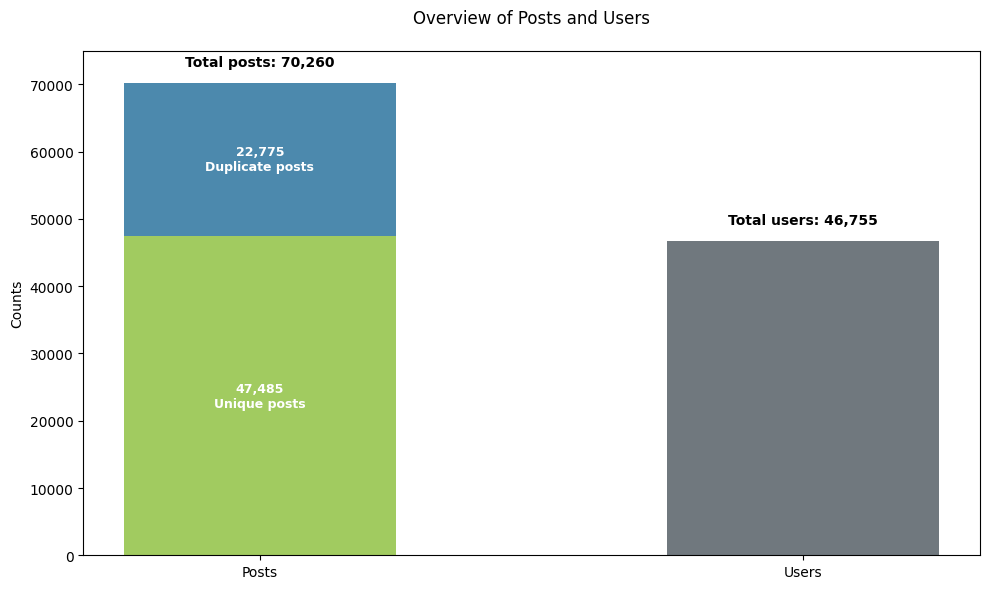

In [ ]:
# Updated bar chart with number of users and bold text inside bars
fig, ax = plt.subplots(figsize=(10, 6))
bars_unique = ax.bar(x, post_counts, bar_width, color=green, alpha=0.7)
bars_duplicate = ax.bar(x, duplicate_counts, bar_width, bottom=post_counts, color=dark_blue, alpha=0.7)
bars_users = ax.bar(x, user_counts, bar_width, color=primary, alpha=0.7)

# Add total annotations above the stacked bars
ax.text(0, total_posts + 2000, f"Total posts: {total_posts:,}", ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.text(1, total_users + 2000, f"Total users: {total_users:,}", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add category labels inside the bars with numbers (bold text)
for bar, value in zip(bars_unique, [unique_posts]):
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height/2, f"{value:,}\nUnique posts", 
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')

for bar, value in zip(bars_duplicate, [duplicate_posts]):
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., post_counts[0] + height/2, f"{value:,}\nDuplicate posts", 
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')

for bar, value in zip(bars_users, [total_users]):
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height/2, f"{value:,}\nUsers", 
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')

# Format the plot
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('Counts')
ax.set_title('Overview of Posts and Users', pad=20)  # Adjust the title position with padding
ax.set_ylim(0, 75000)  # Set the y-axis limit to 75,000

plt.tight_layout()
plt.show()


### Most Active Users

In [32]:
# Identify users with the highest activity
user_activity = df.groupby('user_id').size().reset_index(name='post_count')
top_users = user_activity.sort_values(by='post_count', ascending=False).head(10)
print("Top 10 users with the highest activity:")
print(top_users)

Top 10 users with the highest activity:
          user_id  post_count
4977   1010626427         837
36375  1077881120         178
3600   1007690223         134
14652  1031499948         123
25885  1055454345         116
22969  1049151527         102
38140  1081539622          91
31734  1068051022          86
10609  1022561255          76
3568   1007621559          75


In [33]:
top_user_id = top_users.iloc[0]["user_id"]
top_username = df.loc[df['user_id'] == top_user_id, 'user'].values[0]
print(f"The most active user is {top_username} ({top_user_id})")

The most active user is robert78 (1010626427)


User `1010626427` (username "robert78") is an outlier with $837$ posts, far exceeding the next most active user with $178$ posts, emphasizing their disproportionate activity.

In [34]:
user_posts = original_posts[original_posts['user_id']==top_user_id]["text"]
for i in range(5):
    print(user_posts.values[i])

👀✈️🔊G-WYLD  #GWYLD  #Private  #Cessna T210N Turbo Centurion  From: #Unknown To: #Unknown Alt 2050ft  #40133E   Seen 15 Times   #ClimateEmergency #ScotRadar #COP26 #COP26Glasgow https://t.co/N4T5eWLQVB
👀✈️🔊N807AA  #AAL203  #American Airlines  #Boeing 787 8  From: #AMS Amsterdam Airport Schiphol, Netherlands To: #PHL Philadelphia, United States Alt 39975ft  #AAFBDF   Seen 13 Times   #ClimateEmergency #ScotRadar #COP26 #COP26Glasgow https://t.co/0wRuSQ3iPA
👀✈️🔊G-SAJL  #LOG77A  #Loganair  #Embraer ERJ-145 EP  From: #NWI Norwich, United Kingdom To: #ABZ Aberdeen Dyce, United Kingdom Alt 24000ft  #4007DA   Seen 559 Times   #ClimateEmergency #ScotRadar #COP26 #COP26Glasgow
👀✈️🔊G-PDGV  #Unknown  #PLM Dollar Group  #VulcanAir P.68 TC  From: #Unknown To: #Unknown Alt 6350ft  #40752F   Seen 21 Times   #ClimateEmergency #ScotRadar #COP26 #COP26Glasgow
👀✈️🔊EI-DVL  #EIN317  #Aer Lingus  #Airbus A320 214  From: #EDI Edinburgh, United Kingdom To: #BHD George Best Belfast City, United Kingdom Alt 4900f

## Network Analysis

In [80]:
def get_top_nodes(measure_dict, top_n=10, measure_name="Measure"):
    sorted_items = sorted_items = sorted(measure_dict.items(), key=lambda x: x[1], reverse=True)
    values = [value for _, value in sorted_items]

    top_nodes = sorted_items[:top_n]

    # Display the results
    print(f"Top {top_n} nodes by {measure_name}:")
    print("-" * (15 + len(measure_name)))
    for rank, (node, value) in enumerate(top_nodes, start=1):
        print(f"{rank:>2}. Node: {node}, {measure_name}: {value:.4f}")

    return top_nodes

In [32]:
def plot_graph_with_measure(G, pos, measure, factor=500, edge_width=0.1, alpha=0.7, measure_name="Measure"):
    plt.figure(figsize=(12, 12))

    # Ensure the grid is off
    plt.grid(False)

    matplotlib.rcParams['font.family'] = 'DejaVu Sans'

    # Draw the graph nodes with sizes based on the measure
    node_sizes = [v * factor for v in measure.values()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='light_blue')

    # Draw the graph edges with specified width and transparency
    nx.draw_networkx_edges(G, pos, width=edge_width, alpha=alpha)

    # Add title
    plt.title(f"Graph Visualization with {measure_name} Measure")

     # Enable a box around the graph
    ax = plt.gca()  # Get the current axes
    ax.set_facecolor('none')
    ax.set_frame_on(True)  # Turn on the frame (box around the graph)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

    # Add legends
    node_legend = Line2D([0], [0],color='light_blue', marker='o',  linestyle='None',label=f"Node size ∝ {measure_name}")
    edge_legend = Line2D([0], [0], color='gray', lw=0.3, alpha=1.0, label="Edges")

    plt.legend(handles=[node_legend, edge_legend], loc='upper right')

In [13]:
# Load the graph data
graph_data = pd.read_csv("./data/graph.csv")

# Create an undirected graph using the source and target columns
G = nx.from_pandas_edgelist(graph_data, source='source', target='target')

# Compute the positions of the nodes in the graph G using the Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

### Degree Centrality

Degree centrality quantifies the proportion of users a given user is directly connected to, representing their level of **direct influence or reach** in the network.
In social media analysis, users with high degree centrality are **key influencers or hubs** who can quickly disseminate information to many others, making them critical in campaigns, trends, or spreading information.

count    46849.000000
mean         0.000086
std          0.000195
min          0.000021
25%          0.000043
50%          0.000064
75%          0.000085
max          0.038145
dtype: float64


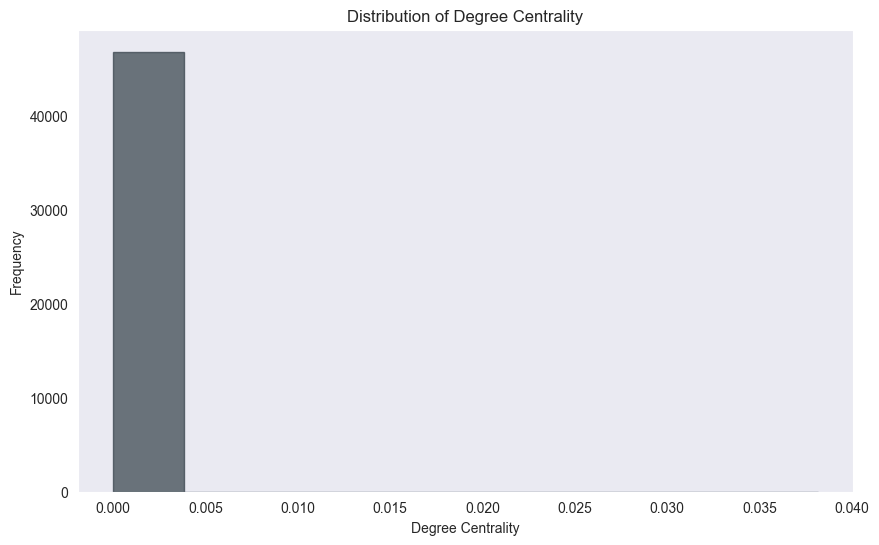

In [14]:
# calculate degree centrality for all users
degree_centrality = nx.degree_centrality(G)
# analyze the distribution of degree centrality
centrality_scores = pd.Series(degree_centrality.values())
print(centrality_scores.describe())

plt.figure(figsize=(10, 6))
plt.grid(False)
plt.hist(centrality_scores, color=primary, edgecolor=primary, alpha=0.7)
plt.title("Distribution of Degree Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")
plt.show()

The network is highly sparse, as the degree centrality distribution shows that most users have extremely low centrality scores (close to 0), with only a few users acting as hubs, indicated by the maximum centrality of 0.0381.

This sparsity could be a result of an incomplete data basis: It might be a cutout of the complete data by limiting the data export to a specific region for instance.

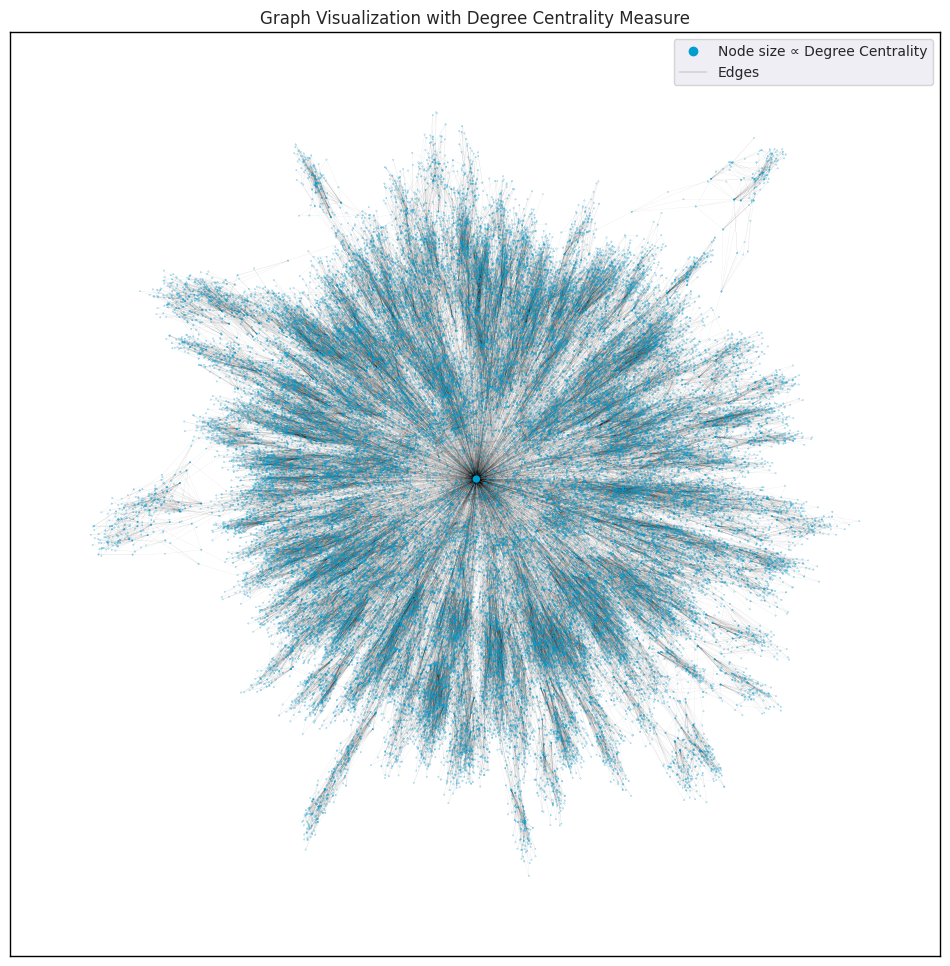

In [43]:
plot_graph_with_measure(G=G, pos=pos, measure=degree_centrality, factor=500, edge_width=0.1, alpha=0.2, measure_name="Degree Centrality")

Larger nodes in the center indicate users with high degree centrality, meaning they are well-connected to other nodes. In contrast, the smaller nodes have lower degree centrality, signifying they have fewer connections.

In [25]:
top_degree_centrality_nodes = get_top_nodes(degree_centrality, top_n=10, measure_name="Degree Centrality")

Top 10 nodes by Degree Centrality:
--------------------------------
 1. Node: 1010626427, Degree Centrality: 0.0381
 2. Node: 1027710225, Degree Centrality: 0.0011
 3. Node: 1018042330, Degree Centrality: 0.0010
 4. Node: 1030048137, Degree Centrality: 0.0010
 5. Node: 1084949174, Degree Centrality: 0.0010
 6. Node: 1066276793, Degree Centrality: 0.0010
 7. Node: 1090990902, Degree Centrality: 0.0010
 8. Node: 1059101695, Degree Centrality: 0.0010
 9. Node: 1047703640, Degree Centrality: 0.0010
10. Node: 1004360689, Degree Centrality: 0.0009
Average Degree Centrality: 0.0001


User `1010626427` stands out as a major hub, being directly connected (friends) to approximately $3.81\%$ of all users, while the rest of the top 10 users have significantly lower centrality, indicating a highly uneven distribution of connections.

### Eigenvector Centrality
Eigenvector centrality measures a **node's importance based on its connections to other important nodes**. It uses an iterative process, updating a node's score based on the scores of its neighbors until a stable state is reached. It is a more refined measurement compared to the Degree Centrality.

In [38]:
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=200)

pd.set_option('display.float_format', lambda x: f'{x:.10f}')

# analyze the distribution of degree centrality
eigenvector_scores = pd.Series(eigenvector_centrality.values())
print(eigenvector_scores.describe())

count   46849.0000000000
mean        0.0007210628
std         0.0045635168
min         0.0000000000
25%         0.0000009377
50%         0.0000103436
75%         0.0000233788
max         0.7058765688
dtype: float64


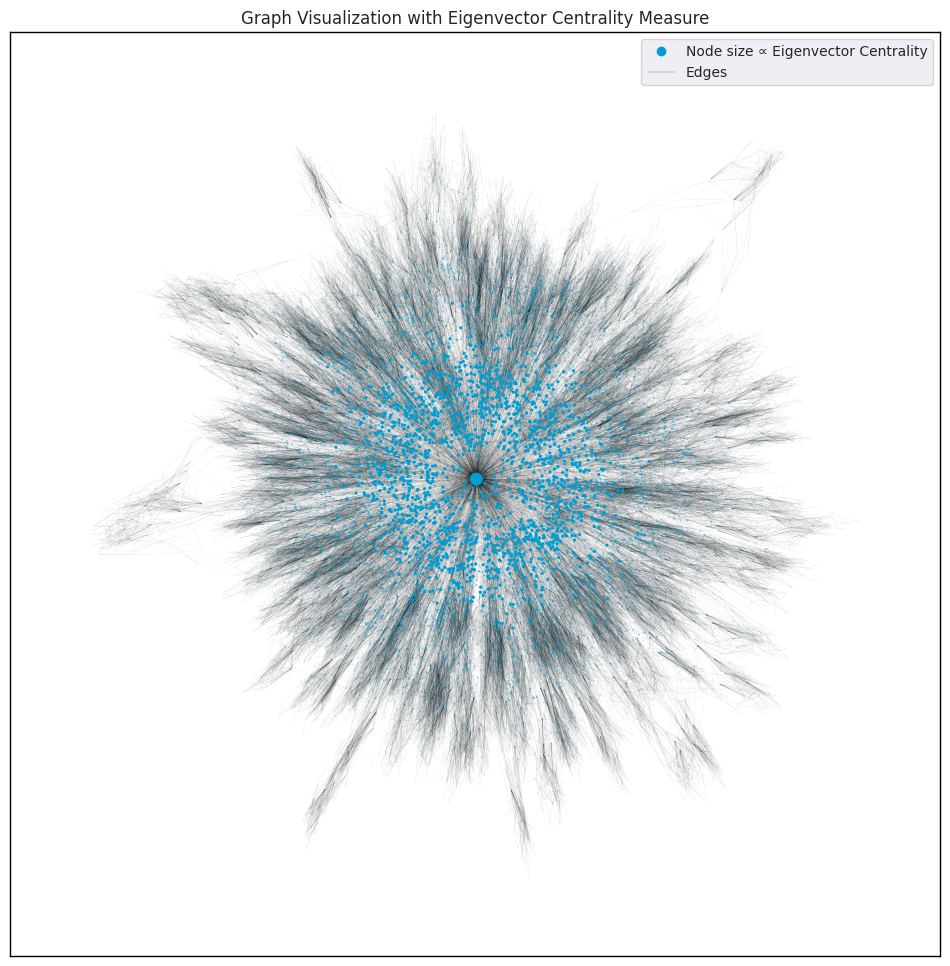

In [44]:
plot_graph_with_measure(G=G, pos=pos, measure=eigenvector_centrality, factor=100, edge_width=0.1, alpha=0.2, measure_name="Eigenvector Centrality")

Larger nodes in the center indicate users with high eigenvector centrality, meaning they are not only well-connected themselves but are also connected to other highly influential nodes. This suggests these central nodes play a crucial role in the overall structure and connectivity of the network. In contrast, the smaller nodes on the periphery have lower eigenvector centrality, signifying they have fewer connections or are connected to less influential nodes. This indicates a less central or less influential role in the network dynamics.

In [42]:
top_eigenvector_centrality_nodes = get_top_nodes(eigenvector_centrality, top_n=10, measure_name="Eigenvektor Centrality")

Top 10 nodes by Eigenvektor Centrality:
-------------------------------------
 1. Node: 1010626427, Eigenvektor Centrality: 0.7059
 2. Node: 1040707594, Eigenvektor Centrality: 0.0189
 3. Node: 1015059112, Eigenvektor Centrality: 0.0183
 4. Node: 1078234461, Eigenvektor Centrality: 0.0182
 5. Node: 1071714676, Eigenvektor Centrality: 0.0182
 6. Node: 1074299054, Eigenvektor Centrality: 0.0180
 7. Node: 1039466578, Eigenvektor Centrality: 0.0180
 8. Node: 1014140623, Eigenvektor Centrality: 0.0179
 9. Node: 1014718318, Eigenvektor Centrality: 0.0178
10. Node: 1080554837, Eigenvektor Centrality: 0.0177


Again, User `1010626427` stands out as a major hub with a Eigenvector Centrality of $0.7059$, while the rest of the top 10 users have significantly lower centrality. This means that `1010626427` is highly influential and important to the surrounding nodes, which positively affects their importance as well.

### Clustering Coefficients

The clustering coefficient measures the likelihood that a user's connections (friends or followers) are also connected to one another, highlighting the local interconnectedness or "tight-knit" groups in the network.

Significance: A high clustering coefficient in social media networks indicates the presence of communities or echo chambers, where users are part of closely-knit groups, fostering information flow or reinforcing specific opinions within those groups.

In [70]:
# Calculate clustering coefficients
clustering_coefficients = nx.clustering(G)
avg_clustering_coefficient = sum(clustering_coefficients.values()) / len(clustering_coefficients)
print(f"Average clustering coefficient: {avg_clustering_coefficient}")

Average clustering coefficient: 0.10242240045186507


 On average, about $10.24\%$ of a user's neighbors are also connected to each other, suggesting that the network exhibits a relatively low level of local connectivity or clustering.

### Closeness Centrality

Closeness centrality measures how quickly a user can reach all other users in the network, based on the shortest paths from that user to others.

Significance: In social media analysis, users with high closeness centrality can efficiently spread information or ideas, making them influential in rapidly propagating trends or news.

In [48]:
closeness_centrality = nx.closeness_centrality(G)

closeness_scores = pd.Series(closeness_centrality.values())
print(closeness_scores.describe())

count   46849.0000000000
mean        0.1569861323
std         0.0243419817
min         0.0820241303
25%         0.1379952281
50%         0.1598651411
75%         0.1600092902
max         0.3063302230
dtype: float64


In [49]:
top_closeness_centrality_nodes = get_top_nodes(closeness_centrality, top_n=10, measure_name="Closeness Centrality")

Top 10 nodes by Closeness Centrality:
-----------------------------------
 1. Node: 1010626427, Closeness Centrality: 0.3063
 2. Node: 1077997466, Closeness Centrality: 0.2365
 3. Node: 1021402235, Closeness Centrality: 0.2362
 4. Node: 1028635896, Closeness Centrality: 0.2356
 5. Node: 1043529958, Closeness Centrality: 0.2356
 6. Node: 1089906253, Closeness Centrality: 0.2355
 7. Node: 1001396520, Closeness Centrality: 0.2353
 8. Node: 1076700886, Closeness Centrality: 0.2352
 9. Node: 1032319872, Closeness Centrality: 0.2351
10. Node: 1032811749, Closeness Centrality: 0.2351


User `1010626427` is the most central in the network, with the highest closeness centrality of $0.3063$ for efficiently reaching others.

### Betweenness Centrality

Betweenness centrality quantifies how often a user acts as a bridge between other users, based on the shortest paths passing through them.

Significance: Users with high betweenness centrality are critical intermediaries in the network, enabling the flow of information between otherwise disconnected groups and often acting as gatekeepers or brokers.

In [45]:
betweenness_centrality = nx.betweenness_centrality(G)

betweenness_scores = pd.Series(betweenness_centrality.values())
print(betweenness_scores.describe())

count   46849.0000000000
mean        0.0001176517
std         0.0045835724
min         0.0000000000
25%         0.0000000155
50%         0.0000003512
75%         0.0000426668
max         0.9896298289
dtype: float64


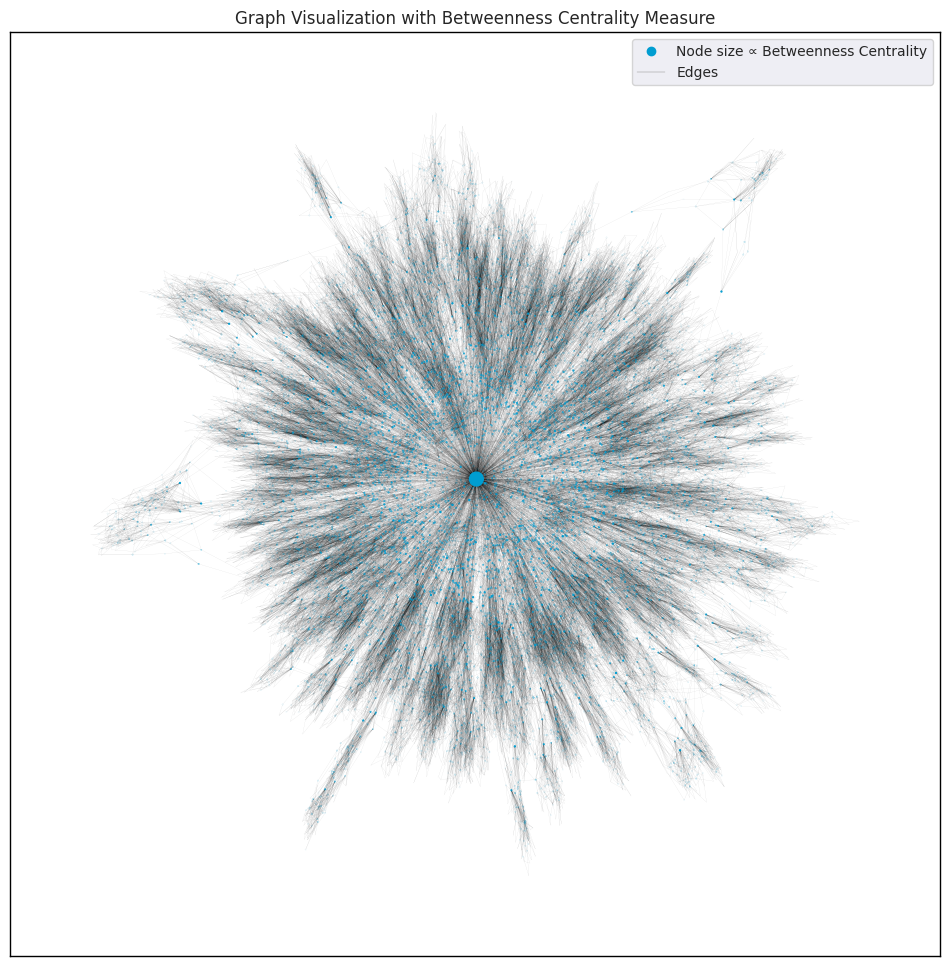

In [46]:
plot_graph_with_measure(G=G, pos=pos, measure=betweenness_centrality, factor=100, edge_width=0.1, alpha=0.2, measure_name="Betweenness Centrality")

Larger nodes in the center indicate users with high betweenness centrality, meaning they lie often on the shortest paths between pairs of other nodes. A node with high betweenness centrality has significant influence over information flow, as it acts as a bridge connecting different parts of the network. In contrast, smaller nodes has low influence over information flow.

In [47]:
top_betweenness_centrality_nodes = get_top_nodes(betweenness_centrality, top_n=10, measure_name="Betweenness Centrality")

Top 10 nodes by Betweenness Centrality:
-------------------------------------
 1. Node: 1010626427, Betweenness Centrality: 0.9896
 2. Node: 1038230812, Betweenness Centrality: 0.0070
 3. Node: 1077997466, Betweenness Centrality: 0.0060
 4. Node: 1019871970, Betweenness Centrality: 0.0059
 5. Node: 1032319872, Betweenness Centrality: 0.0059
 6. Node: 1075438118, Betweenness Centrality: 0.0058
 7. Node: 1001396520, Betweenness Centrality: 0.0054
 8. Node: 1037467053, Betweenness Centrality: 0.0054
 9. Node: 1046974586, Betweenness Centrality: 0.0053
10. Node: 1084348320, Betweenness Centrality: 0.0053


User `1010626427` has an overwhelmingly high betweenness centrality of $0.9896$, indicating a critical role as a bridge connecting otherwise separate groups.

### Inspection of Friendships

In [74]:
# Combine the 'source' and 'target' columns
all_friends = pd.concat([graph_data['source'], graph_data['target']])

# Count occurrences of each user ID
friendship_counts = all_friends.value_counts()

# Sort the counts in descending order (ensured)
friendship_counts = friendship_counts.sort_values(ascending=False)

# Calculate the mean and maximum of the total number of friends
mean_friends = friendship_counts.mean()
max_friends = friendship_counts.max()

print(f"Mean number of friends: {mean_friends:.2f}")
print(f"Maximum number of friends: {max_friends}")

# Display the top users with the highest friends count
print(friendship_counts.head())

Mean number of friends: 4.05
Maximum number of friends: 1787
1010626427    1787
1027710225      53
1018042330      49
1030048137      49
1084949174      46
Name: count, dtype: int64


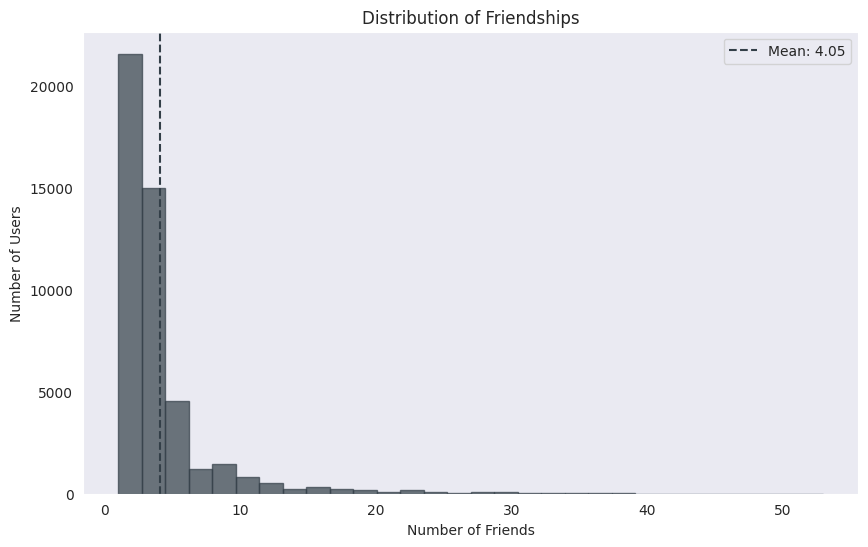

In [78]:
# Plot the distribution of friendships
plt.figure(figsize=(10, 6))
plt.grid(False)
# The outlier with the user_id 1010626427 is excluded here to enable a meaningful visualization
plt.hist(friendship_counts[1:], bins=30, edgecolor=primary, alpha=0.7, color=primary)
plt.axvline(mean_friends, color=primary, linestyle='--', linewidth=1.5, label=f'Mean: {mean_friends:.2f}')
plt.title('Distribution of Friendships')
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')
plt.legend()
plt.show()

### Community Analysis
The Louvian algorithm optimizes a measure called modularity, which quantifies the density of edges within communities compared to the density of edges between communities. The Louvain method does not analyze the text or any other content inside the nodes of the graph. It purely operates on the structure of the graph. The calculation of the final communities has some randomness to it, where the size of the community changes slightly each time it is run.

In [60]:
# Louvain community detection
partition = community_louvain.best_partition(G)
print(f"Detected communities: {len(set(partition.values()))}")

# Add nodes to communities
for node, community in partition.items():
    G.nodes[node]['community'] = community

Detected communities: 246


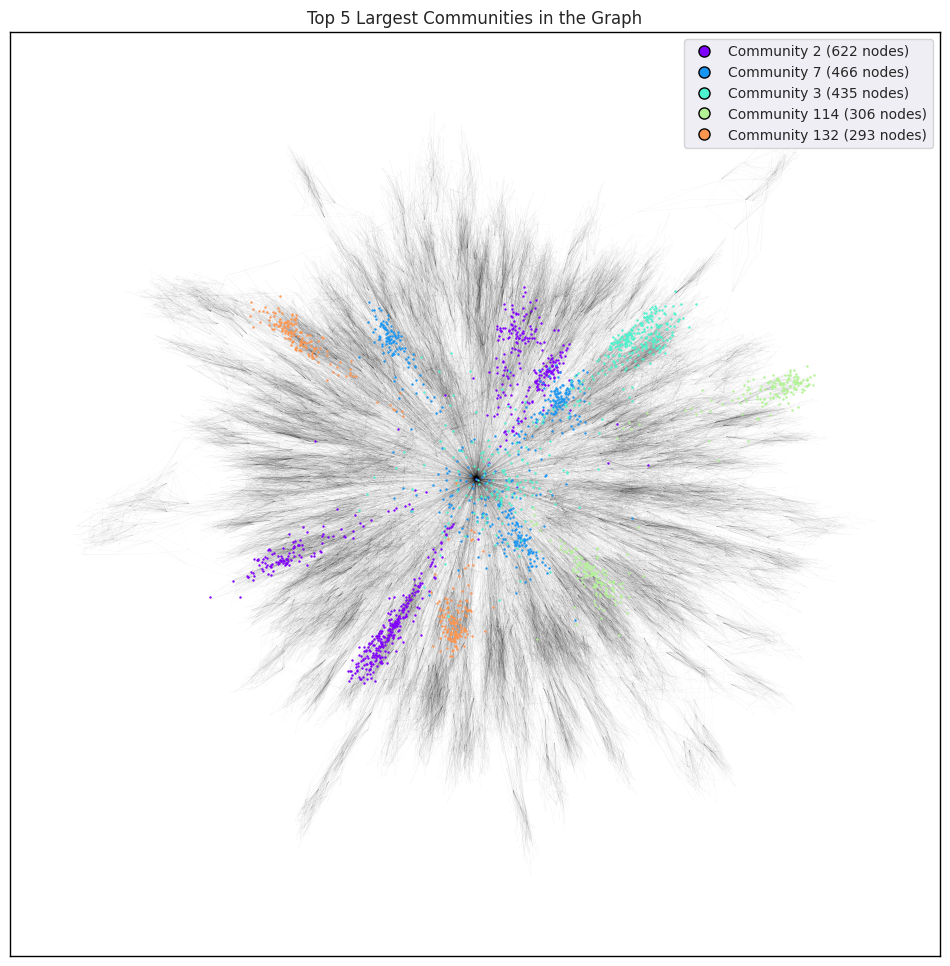

In [77]:
# Count the number of nodes in each community
community_sizes = Counter(partition.values())
top_5_communities = [community for community, _ in community_sizes.most_common(5)]

# Visualize the graph
plt.figure(figsize=(12, 12))
# Ensure the grid is off
plt.grid(False)
# Draw all edges faintly for context
nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.1)

# Highlight nodes in the top 5 communities
colors = plt.cm.rainbow([i / len(top_5_communities) for i in range(len(top_5_communities))])
legend_elements = []
for community, color in zip(top_5_communities, colors):
    nodes_in_community = [node for node, com in partition.items() if com == community]
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodes_in_community,
        node_size=0.5, node_color=[color],
        label=f"Community {community} ({community_sizes[community]} nodes)"
    )
    # Add legend entry with matching size and color
    legend_elements.append(Line2D(
        [0], [0],
        marker='o', color='none', label=f"Community {community} ({community_sizes[community]} nodes)",
        markerfacecolor=color, markersize=8  # Set size of legend circle
    ))

# Enable a box around the graph
ax = plt.gca()  # Get the current axes
ax.set_facecolor('none')
ax.set_frame_on(True)  # Turn on the frame (box around the graph)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Add a legend
plt.legend(handles=legend_elements, scatterpoints=1, loc="best", fontsize=10)

plt.title("Top 5 Largest Communities in the Graph")
plt.axis('equal')  # Fix aspect ratio
plt.show()

In [62]:
# Outlier user
user_id = 1010626427

# Get the user's community
user_community = partition.get(user_id, None)

if user_community is not None:
    print(f"User {user_id} belongs to community {user_community}.")
else:
    print(f"User {user_id} is not in the graph.")

User 1010626427 belongs to community 2.


In most cases, user `1010626427` is in the largest community. In this case, he is in community 2, which has a size of 622 nodes.

In [67]:
# Add community labels to the DataFrame
df['community'] = df['user_id'].map(partition)

# Find the top 5 communities by the number of users
top_5_communities = df['community'].value_counts().head(5).index

# Loop through each of the top 5 communities
for community_index in top_5_communities:
    # Filter text for the specific community
    community_text = df[df['community'] == community_index]['text']

    # Vectorize the text
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    dtm = vectorizer.fit_transform(community_text)

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=2, random_state=42)
    lda.fit(dtm)

    # Extract topics
    topics = lda.components_
    terms = vectorizer.get_feature_names_out()

    # Print topics for the current community
    print(f"\nCommunity {community_index} Topics:")
    for idx, topic in enumerate(topics):
        print(f"  Topic {idx}: ", [terms[i] for i in topic.argsort()[-10:]])


Community 2 Topics:
  Topic 0:  ['vote', 'politics', 'just', 'time', 'check', 'yhawkins', 'let', 'business', 'health', 'https']
  Topic 1:  ['https', 'united', 'cop26glasgow', 'scotradar', 'cop26', 'climateemergency', 'alt', 'seen', 'times', 'unknown']

Community 7 Topics:
  Topic 0:  ['missing', 'airport', 'snow', 'precip', 'oct', 'high', '31', 'low', 'climate', 'https']
  Topic 1:  ['time', 'just', 'check', 'support', 'vote', 'yhawkins', 'let', 'health', 'business', 'https']

Community 25 Topics:
  Topic 0:  ['term', 'time', 'check', 'vote', 'yhawkins', 'just', 'let', 'business', 'health', 'https']
  Topic 1:  ['eruption', 'effective', 'read', 'real', 'joebiden', 'potus', 'https', 'stop', 'change', 'climate']

Community 3 Topics:
  Topic 0:  ['university', 'dogs', 'campuses', 'pawsforlearning', 'fluffy', 'movement', 'bring', 'make', 'join', 'let']
  Topic 1:  ['yhawkins', 'world', 'politics', 'support', 'check', 'time', 'love', 'health', 'business', 'https']

Community 118 Topics:
 

**Similarities**
- communities focus on overlapping topics like politics, health, and business
- The keyword **yhawkins** is a topic across all top 5 communities
- Community 7, 25, and 118, have topics related to climate and environmental issues (e.g., "climate," "cop26," "climateemergency")
- The keyword https is frequently mentioned, indicating the usage of links or online references in discussions

**Differences**
- Community 2 references **"cop26glasgow"**, **"scotradar"**, **"seen"**, **"alt"** and **"times"**
- Community 7 includes words like "snow" "precip" "airport" and dates like "oct"
- Community 25 mentions "joebiden" and "potus" showing discussions around political figures
- Community 3 has a distinct focus on **universities and dogs**
- Community 118 includes keywords related to quizzes (e.g., "test," "quiz," "knowledge")





## **Stream Clustering**

As the data is recorded social media data with timestamps, we are dealing with a recorded data stream. Hence, it makes a lot of sense to use stream clustering and the textClust algorithm instead of normal clustering. This allows us to analyse the behaviour of the data over time and detect any concept drift. Therefore, we intialise a pipeline.

Since the results of the macro clustering always led to one big merged cluster and several other macro clusters containing 1 micro cluster, we decided to only apply phase 1 of the usual two-phase Stream Clustering approach. Thus, we tracked the micro clusters and adapted the textClust parameters so that we got as meaningful clusters as possible.

### Pipeline & textClust Setup
    

In [49]:
df['minute_of_day'] = df['datetime'].dt.hour * 60 + df['datetime'].dt.minute

In [50]:
#Setting parameters for the TextClust algorithm
text_clust_algo = cluster.TextClust(real_time_fading=False, fading_factor=0.001, tgap=100, auto_r=False, radius=0.6)

model = compose.Pipeline(
    #Utilize feature extraction by river to convert text into ngrams of size 1 and 2, no stopwords needed since we preprocessed the tweets already
    feature_extraction.BagOfWords(lowercase=True, ngram_range=(1, 2), stop_words=[]),
    text_clust_algo,
)

In [51]:
old_time = df.loc[0, 'minute_of_day']
log = []

# Iterate over the rows of the dataframe
for index, row in df.iterrows():
    text = row['text_preprocessed']
    #assign tweet to a micro-cluster
    model.learn_one(text)

    # Check if the minute has changed
    if row['minute_of_day'] != old_time:
        old_time = row['minute_of_day']
        micro_clusters = text_clust_algo.micro_clusters

        # Log weight, id, terms and size of each micro-cluster
        for key, micro_cluster in micro_clusters.items():
            weight = micro_cluster.weight
            log.append({'minute_of_day': old_time, 'micro_cluster_id': key, 'weight': weight, 
                        'terms': [term[0] for term in list(micro_cluster.tf.items())], 'cluster_size': len(micro_cluster.tf.items())})

log_df = pd.DataFrame(log)

### Visualization

In [52]:
high_weight_ids = log_df[log_df['weight'] > 40]['micro_cluster_id'].unique().tolist()
high_weight_ids

[67, 1740, 18052, 31466, 36270, 43620, 89]

To analyse the contents of each micro-cluster, we used the Visual Studio Code extension Data Wrangler because it makes data analysis much easier. To document where our results come from, we have created the data frames for each cluster below, which can be examined.

It can be seen, that the Stream Clustering with our chosen textClust settings (radius of $0.6$) clearly reveals **various bot / campaign tweets**, that all either stem from one account or from multiple ones posting the same / similar posts. The **#PawsForLearning** cluster is clearly recognisable and looks very suspicious since its weight doesn't even build up like for example the "Climate Fudge Cake" bot. It just jumps straight to one of the highest weights in the whole Stream Clustering because most of the tweets arrive in the same second.

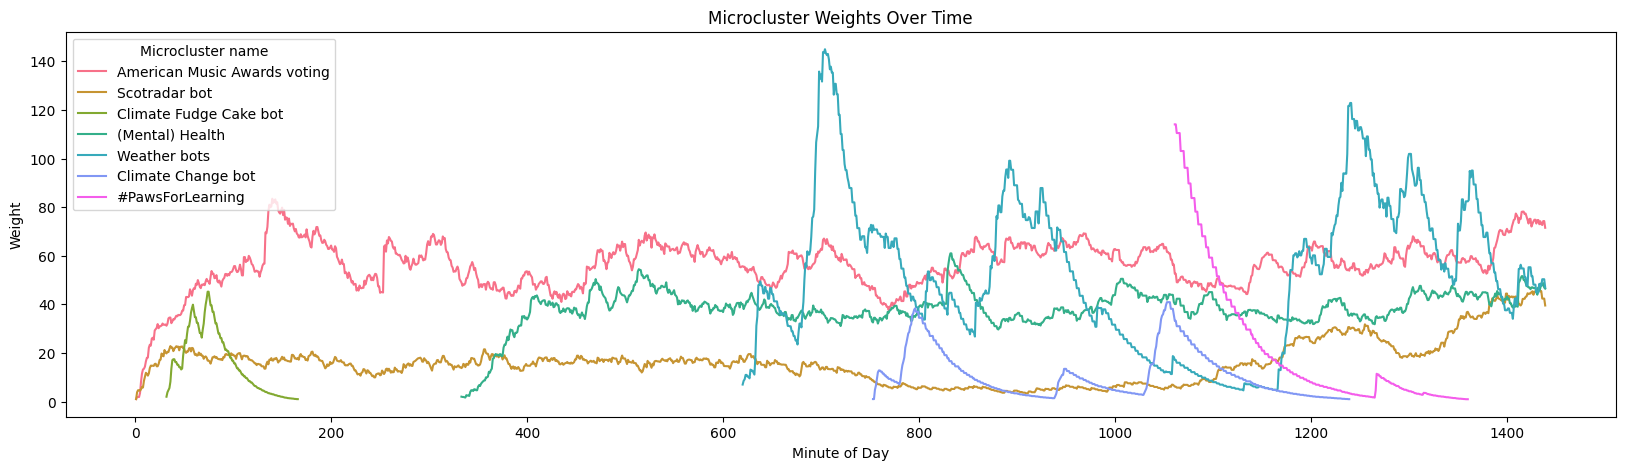

In [53]:
# Filter the log_df for the important microcluster ids
filtered_log_df = log_df[log_df['micro_cluster_id'].isin(high_weight_ids)]

# Plot the data
plt.figure(figsize=(20, 5))
palette = sns.color_palette("husl", len(high_weight_ids))

# Define a mapping of microcluster IDs to names
microcluster_names = {
    67: 'American Music Awards voting',
    89: 'Scotradar bot',
    1740: 'Climate Fudge Cake bot',
    18052: '(Mental) Health',
    31466: 'Weather bots',
    36270: 'Climate Change bot',
    43620: '#PawsForLearning'
}

# Map the microcluster IDs to names
filtered_log_df['micro_cluster_name'] = filtered_log_df['micro_cluster_id'].map(microcluster_names).fillna(filtered_log_df['micro_cluster_id'].astype(str))

# Plot the data with names
sns.lineplot(data=filtered_log_df, x='minute_of_day', y='weight', hue='micro_cluster_name', palette=palette)
plt.xlabel('Minute of Day')
plt.ylabel('Weight')
plt.title('Microcluster Weights Over Time')
plt.legend(title='Microcluster name')
plt.show()

In [54]:
cluster_df_am_awards = log_df[log_df['micro_cluster_id'] == 67]
cluster_df_scotradar = log_df[log_df['micro_cluster_id'] == 89]
cluster_df_climate_fudge_cake = log_df[log_df['micro_cluster_id'] == 1740]
cluster_df_mental_health = log_df[log_df['micro_cluster_id'] == 18052]
cluster_df_weather_bots = log_df[log_df['micro_cluster_id'] == 31466]
cluster_df_climate_change = log_df[log_df['micro_cluster_id'] == 36270]
cluster_df_paws_for_learning = log_df[log_df['micro_cluster_id'] == 43620]


With the data wrangler we then searched df[text] and df[text_preprocessed] for the various original tweets. Which revealed that for example all "Climate Fudge Cake" tweets and a big amount of the climate change cluster tweets all came from one account each.

## Duplicate Text Analysis

In [8]:
df_duplicates = df[df['text'].duplicated(keep=False)]
duplicate_groups = df_duplicates.groupby('text').size().reset_index(name='count').sort_values(by='count', ascending=False)

duplication_distribution = duplicate_groups['count'].value_counts().sort_index()
duplication_distribution  

#TODO: Markdown Comment

count
2      11313
3       3330
4        830
5        224
6         55
7         23
8         26
130        1
Name: count, dtype: int64

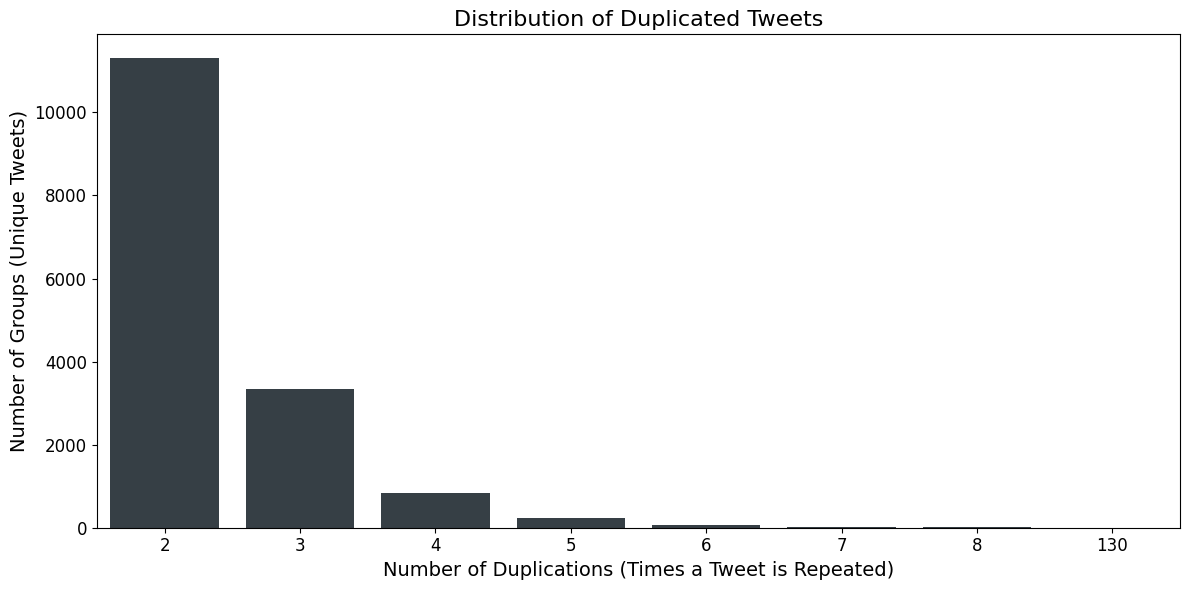

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=duplication_distribution.index, y=duplication_distribution.values, color=primary)
plt.title("Distribution of Duplicated Tweets", fontsize=16)
plt.xlabel("Number of Duplications (Times a Tweet is Repeated)", fontsize=14)
plt.ylabel("Number of Groups (Unique Tweets)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
high_count_duplicate_groups = duplicate_groups[duplicate_groups['count'] >= 5]
high_count_duplicate_groups.head()

text  count
6397   Bring comfort dogs to every university lecture...    130
6163   Be mindful of your diet and exercise to stay h...      8
10327  Increase your website traffic for your home bu...      8
14905  Uncover the key strategies to boost your onlin...      8
12703  Reclaim your health and shed those unwanted fa...      8

In [11]:
preprocessed_high_count_duplicate_groups = [normalize_text(tweet) for tweet in high_count_duplicate_groups['text']]

In [12]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_high_count_duplicate_groups)
cosine_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
complete_linkage_duplicates_high_count = linkage(cosine_similarity_matrix,method='complete')

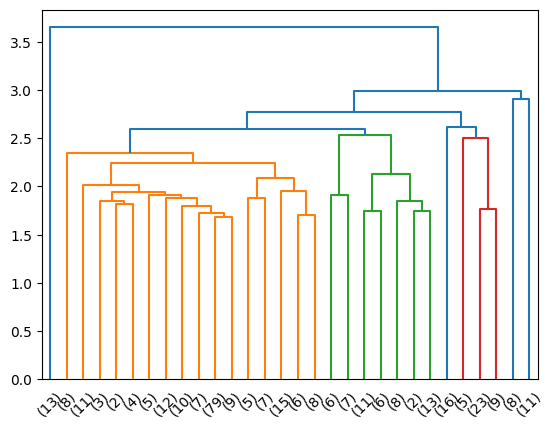

In [13]:
dendrogram(complete_linkage_duplicates_high_count, truncate_mode='lastp', p=30)
plt.show()
#TODO: Markdown Comment on CLustering and Dendrogram and explain runtime problem

In [14]:
threshold = 2.4
#6.3  # Replace with the value identified from the dendrogram
clusters = fcluster(complete_linkage_duplicates_high_count, t=threshold, criterion='distance')
high_count_duplicate_groups['cluster'] = clusters
print(f"Nr of cluster {high_count_duplicate_groups['cluster'].nunique()}")

Nr of cluster 9


C:\Users\Simon.Luttmann\AppData\Local\Temp\ipykernel_14424\519388936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_count_duplicate_groups['cluster'] = clusters


In [15]:
high_count_duplicate_groups['cluster'].value_counts().sort_index()

cluster
1     13
2    191
3     13
4     40
5     16
6      5
7     32
8      8
9     11
Name: count, dtype: int64

In [16]:
silhouette_avg = silhouette_score(tfidf_matrix, clusters)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.06379683287039095


### Cluster Content

In [20]:
i = 1
print(f"Cluster {i}")
for j in range(5): 
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 1
Looking for affordable and fast web hosting for your business, blog, or e-commerce store? Check out https://t.co/PVVQvS3B4k and start making money with your new website! #webhosting #business #ecommerce
Looking for affordable and fast web hosting for your business, blog, or e-commerce store? Check out this option ⬇️ [link] Create a website and start making money! #webhosting #business #blogging
Looking for affordable and lightning-fast web hosting for your business, blog, or e-commerce store? Check out the options here ➡️ [link] Create your website and start making money today! #webhosting #business #ecommerce
Looking for affordable and reliable web hosting for your business or blog? Check out the fastest options here ⬇️  https://t.co/Pgq6ESqTdu Start creating your website and making money! #webhosting #business #blogging
Looking for affordable and speedy web hosting for your business, blog, or e-commerce store? Check out this option! 💻💰 #webhosting #business #blogging


In [21]:
i = 2
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 2
Bring comfort dogs to every university lecture! 🎓❤🐶️ Let's make our campuses fluffy again! Join the movement! #PawsForLearning #UniMS
Uncover the key strategies to boost your online business with this insightful video 🚀💰 #InternetBusiness #SuccessTips #Motivation https://t.co/RyuLCxUsHp
Discover the secrets of successful home business talks with potential customers on social media. This training video could change the game for you. 🔥💼 #BusinessTips #Entrepreneurship https://t.co/8STXltSvnx
Looking to attract more clients for your home business? Check out this formula: https://t.co/TuzMwmiZai #HomeBusiness #Clients #Success
Discover the keys to internet business success in this insightful video 📹 #Courage #BePositive #Motivation #SocialMedia https://t.co/hTCyYWl0Mx


In [22]:
i = 3
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 3
Since 2007, Global Fund has empowered 2,371 HCWs and 930 students to improve health facilities and training institutions. 68% HCWs have transitioned into government systems, accelerating ATM. #GlobalHealth @thomasmaria 🌍🏥
Since 2007, Global Fund has supported 2,371 healthcare workers and 930 students, placed in 500 health facilities and 47 training institutions to accelerate access to medicine. To date, 68% of healthcare workers have transitioned to government systems for sustainability. #GlobalHealth @chelsea06 #HealthcareWorkers #MedicineAccess
Since 2007, Global Fund has supported the deployment of over 2,300 healthcare workers and over 900 students, helping to strengthen health facilities and training institutions. The impact is clear with 68% of HCWs now in government systems. #GlobalHealth #HealthcareWorkers
Since 2010, our foundation has supported over 3,000 healthcare workers and 1,200 students, enhancing 600+ health facilities to advance access to healthcare. Our imp

In [23]:
i = 4
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 4
Be mindful of your diet and exercise to stay healthy. Learn more about these important concepts at our website. 💪🥦 #HealthyLiving #Wellness https://t.co/gFsPis6PAk
Increase your website traffic for your home business with this alternative! 👉 https://t.co/e1j0M4rGXo 👈 #entrepreneur #onlinebusiness

Start your journey to better health and weight loss with this informative video overview! 👉 https://t.co/PrcBKEqSBR 👈 #healthylifestyle #weightloss
Reclaim your health and shed those unwanted fat cells with these amazing tips! You can easily jumpstart your weight loss journey and regain your vitality. #WeightLoss #HealthyLiving 🏋️‍♂️💪
Don't put your health at risk by storing excess fats. Check out this video for tips on maintaining a healthy diet and lifestyle. #Diet #GymLife https://t.co/5VGgRa7UWc https://t.co/rjtU5fWTo0
Don't put your health at risk by ignoring unwanted body fat. Check out this quick technique to improve your well-being. #Health https://t.co/LMbJq3Q9ji https://t.

In [26]:
i = 5
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 5
@vrobinson: @brendamedina @ywagner @katherine35 @ashleytodd @cheyennewilliamson @derrick48 @elizabethwilliams @marissalee @hintonjennifer So excited for the upcoming event! 🎉 Who’s ready to party? 🌟 Let’s make unforgettable memories together! 💖 #ALDUBForever #FandomGoals 📅✨
@vrobinson: @brendamedina @ywagner @katherine35 @ashleytodd @cheyennewilliamson @derrick48 @elizabethwilliams @marissalee @hintonjennifer We’re all here waiting for the big reveal! 🌟 Can't wait to see what’s in store 💖 #ALDUBMagic #TeamAwesome https://t.co/Jq2ejcxo9T
@greenrebecca: @brendamedina @ywagner @katherine35 @ashleytodd @cheyennewilliamson @derrick48 @elizabethwilliams @marissalee @hintonjennifer So many memories in just one pic! 😍❤️ #ALDUBForever #MemoriesMade 📸✨
@abigailwillis: @brendamedina @ywagner @katherine35 @ashleytodd @cheyennewilliamson @derrick48 @elizabethwilliams @marissalee @hintonjennifer… Can't believe the hype for the new album! 🎶✨ Who's ready to jam? #MusicLovers #ALDubFam @fjame

In [27]:
i = 6
print(f"Cluster {i}")
for j in range(5):   
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 6
@nbarnett 🚫 WRONG hashtag!! -&gt; ❌ #KPOPBATTLE the CORRECT one is -&gt; ✅ #KPOPCROWN Please just use ONLY 1 hashtag!! ^-^ or your vote WILL NOT COUNT ^-^
@melissaramirez 🚫WRONG hashtag!! -&gt; ❌#KPopAwards2023 the CORRECT one is -&gt; ✅ #KPopAwards2024 Remember, only ONE hashtag matters for your vote to COUNT! 🌟 Don't miss out! ^-^
@walkernathan WRONG hashtag!! -&gt; ❌#ArianaAwards the CORRECT one is -&gt; ✅ #ArianaGrammy2024 Please just use ONLY 1 hashtag!! ^-^ or your vote WILL NOT COUNT ^-^
@garcialeah 💖WRONG hashtag alert! -&gt; ❌ #BTSFANS2023 the RIGHT one is -&gt; ✅ #BTSFAN2023 Just stick to ONE hashtag, please!! ^-^ or your vote WILL NOT COUNT!! 🎉 #VoteBTS #ARMYUnited
@qpatterson Incorrect hashtag!! -&gt; ❌#BTSFANATICS the CORRECT one is -&gt; ✅ #BTSATW Please just use ONLY 1 hashtag!! ^-^ or your vote WILL NOT COUNT ^-^


In [28]:
i = 7
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 7
@nbarnett: . greetings from Brazil! . just cast my vote for @yhawkins as TOP SOCIAL ARTIST at the #BBMAs! . They inspire us every day! ❤️🌟 #VoteBTS #ARMYForever . 🐾💜
.@lawrenceruben: 🌟 Annyeonghaseyo, fellow ARMY! 🌟 Just cast my vote for @yhawkins at the #BBMAs! They inspire us all with their music and love! 🥰 Let’s show them our support! #BTSforBBMAs #VoteBTS 💜💜💜 Check this out ➡️ www.btsvote.com
@pamela95: Just finished my voting for @yhawkins at the #BBMAs! 🎉🖤 Can’t wait to see them shine as Top Social Artist! 🌟 Who else is excited? #BTSBBMAs #ARMYforever 💜💜
@dunnnicholas: @beanjustin @ryanbates @yhawkins Ready to show the world who's boss! Voted for @yhawkins for #BBMAs Top Social Artist! 🤩💜 It’s time to prove why they’re the best! #ARMYPower #VoteBTS 🔥🎤 https://t.co/TdPqd217q9
@qgonzales: @laura61 @mflores @yhawkins I vote @yhawkins for the #BTSBBMAs Top Social Artist Award Can't wait to see their amazing performance!✨💜


Cluster 7 seems to contain a lot of mentions of "@yhawkins" let's check how many instances there are of this in total.

In [33]:
mentions =  df[df['text'].str.contains("@yhawkins", na=False)].shape[0]
print(f"Number of mentions of @yhawkins: {mentions}")


Number of mentions of @yhawkins: 6226


In [29]:
i = 8
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 8
Seeking beautiful art for your home or office? Look no further! 🎨 I've got you covered with framed artworks and canvas paintings. Check out my collection at https://t.co/mylMH1blJw #art #homedecor
Looking to beautify your space with some stunning artwork? Look no further, I've got you covered! 🎨 Check out my collection here: [link] #art #homedecor
Looking to elevate your space with stunning artwork? Look no further! Whether it's for your home or office, I've got you covered 🎨❤️ #art #homedecor https://t.co/aLAFh2Xkdv
Looking to spruce up your space with some beautiful art? I've got you covered! Check out my selection of framed artworks and canvas paintings 🎨 #homedecor #artlovers #interiordesign https://t.co/uYkHIalTSX
Looking for stunning framed artworks or canvas paintings for your home or office? 🎨 Check out my collection, I've got you covered! 🔌 #art #homedecor https://t.co/34zzZlY1wz


In [30]:
i = 9
print(f"Cluster {i}")
for j in range(5):
    print(high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text'].iloc[j])

Cluster 9
Looking for HLT-362V-O503 Topic 2 DQs or Article Analysis 1 from GCU? Check out the links to download the course materials! 📚 #GCU #CourseMaterials https://t.co/ldNrf1KHlN
Explore the application of statistics in healthcare with HLT-362V-O503 Topic 1 at GCU. Download the course here: https://t.co/klBynbdLuy #healthcare #statistics #GCU
Looking for HLT-362V-O503 course materials? Check out these links for Topic 5 Discussion Questions and Topic 3 Article Analysis 2 from GCU. 📚 #GCU #CourseMaterials #HealthcareAnalysis https://t.co/9n2CEFRAf7 https://t.co/dasXyzFdjA https://t.co/sgqXSzpA6c https://t.co/NChkV3focD
Need help with your Quality Improvement Proposal for HLT-362V-O503 Topic 4 at GCU? Check out this link for resources: https://t.co/3hfD5qWpig 📚 #GCU #Healthcare #QualityImprovement
Need help with Topic 5 Article Analysis & Research Ethics? Click the link to download the course: https://t.co/xrUfWGDkdq #GCU #researchethics


### User and Post Cluster-Analysis

In [31]:
for i in high_count_duplicate_groups['cluster'].sort_values().unique():
    # Step 1: Filter high_count_duplicate_groups for cluster 1
    cluster_tweets = high_count_duplicate_groups[high_count_duplicate_groups['cluster'] == i]['text']

    # Step 2: Filter the original df for these tweets and get the user IDs
    users_in_cluster = df[df['text'].isin(cluster_tweets)]['user_id']

    tweets_in_cluster = users_in_cluster.shape[0]
    print(f"Nr of tweets in cluster {i}: {tweets_in_cluster}")
    # Optionally, get unique user IDs
    unique_users_in_cluster = users_in_cluster.unique()

    print(f"Nr of unique users in cluster {i}: {unique_users_in_cluster.shape[0]}")
    print(f"tweets/users ratio: {tweets_in_cluster / unique_users_in_cluster.shape[0]}")

Nr of tweets in cluster 1: 65
Nr of unique users in cluster 1: 5
tweets/users ratio: 13.0
Nr of tweets in cluster 2: 1169
Nr of unique users in cluster 2: 549
tweets/users ratio: 2.1293260473588345
Nr of tweets in cluster 3: 65
Nr of unique users in cluster 3: 5
tweets/users ratio: 13.0
Nr of tweets in cluster 4: 278
Nr of unique users in cluster 4: 35
tweets/users ratio: 7.942857142857143
Nr of tweets in cluster 5: 80
Nr of unique users in cluster 5: 10
tweets/users ratio: 8.0
Nr of tweets in cluster 6: 25
Nr of unique users in cluster 6: 5
tweets/users ratio: 5.0
Nr of tweets in cluster 7: 172
Nr of unique users in cluster 7: 73
tweets/users ratio: 2.356164383561644
Nr of tweets in cluster 8: 40
Nr of unique users in cluster 8: 5
tweets/users ratio: 8.0
Nr of tweets in cluster 9: 55
Nr of unique users in cluster 9: 5
tweets/users ratio: 11.0


Here we can see that many clusters from 'texts' with 5 or more duplicates have been created by few users. However Cluster 2 and 7 have tweets/user ratios which are closer to 2 which is low considering the high amount of duplicates considered